In [1]:
# SETUP INSTRUCTIONS
# Run each cell below to set up environment
# Make sure to adjust subjectid and path variables
# Run pupillabs test BEFORE this protocol to ensure measurements are as expected
# Also ensure that you have created a subfolder in the "subjectdata" folder with the subject number: sub-xxx
path_base = 'C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/' #update "kebl6975" with your ID
subject_id = 49 # replace subject ID here as a number with no leading zeros, e.g. 1, 30, 101
subj_base = 'sub-049/pipr-90s-binoc-sub-049_ses-01_dat-20240827' # sub-subjectID/pipr-90s-binoc-sub-subjectID-ses-sesID-dat-yyyymmdd

In [2]:
# Set up stlab (light engine). Make sure you have turned it on before running this!
from pyplr import stlab
d = stlab.SpectraTuneLab(password='2294b16eea08a15a')
d.turn_off()

LIGHT HUB login success
User authenticated as: admin
The following addresses are defined: [1, 1004, 1023]
Call get_luminaires() / get_device_info() for more info


<Response [200]>

Light engine is now set up, and so it is now possible to access the methods from the REST API. 

(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


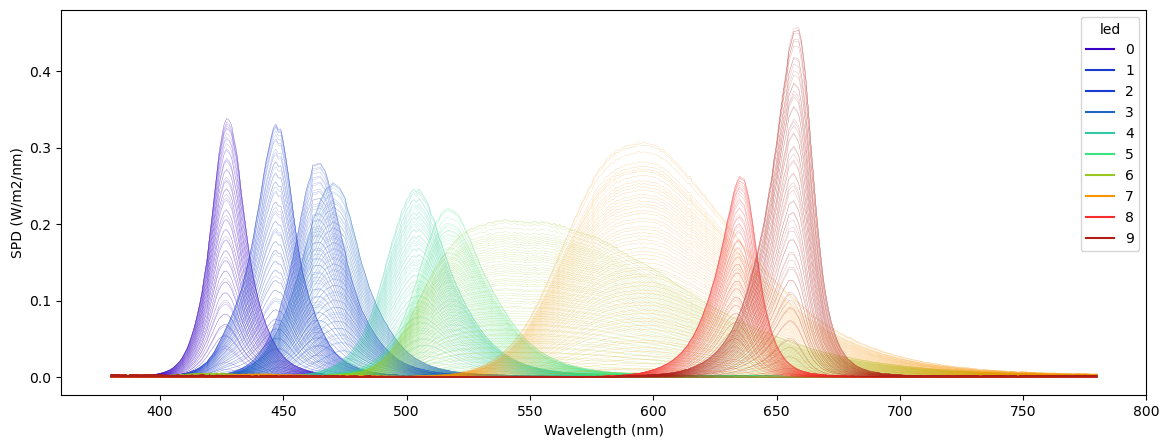

In [3]:
# Calibration - important to run to ensure colours are as expected
import pyplr.calibrate as calb
from importlib import reload
reload(calb)
# file type to be read must be in format of:
# led | intensity | wavelength 1 (380) | wavelength 2 | ... | wavelength n (780)

cc = calb.CalibrationContext(
    'S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()


In [4]:
# calculate the peak spectral sensitivity for each LED at its maximum intensity setting
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
(0,)    427
(1,)    447
(2,)    465
(3,)    470
(4,)    505
(5,)    517
(6,)    540
(7,)    594
(8,)    635
(9,)    659
dtype: object

In [5]:
blue_led = (3,) #blue_led = 3. Had to change because of object type
red_led = (9,) #red_led = 9
target_lux = 800

# Find the required intensity setting of the blue led for 800 lux
blue_intensity = (cc.lux.loc[blue_led].sub(target_lux)
                                      .abs()
                                      .idxmin())
#                                     .values[0])

# Find the intensity setting of the red led for 800 lux
red_intensity = cc.match(match_led=blue_led,
                         match_led_intensity=blue_intensity,
                         target_led=red_led,
                         match_type='irrad')[1]

In [6]:
# note: melanopsin plot has been cut from cell above
from pyplr import stlab
import pandas as pd

# sets the blue and red light specifications
blue_spec, red_spec = [0]*10, [0]*10
blue_spec[pd.to_numeric(blue_led)[0]] = blue_intensity
red_spec[pd.to_numeric(red_led)[0]] = red_intensity
d.turn_off()

<Response [200]>

In [7]:
from time import sleep
# import random # not using this library unless we want to randomize stims
from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.protocol import input_subject_id, subject_dir
# Connect to Pupil Core - make sure you have turned on PupilCore software before running this cell
p = PupilCore()
p.check_3d_model() # asks whether to "refit" the model. If circles around pupils aren't dark blue, refit model

> Refit the 3d model? [y/n]:  n


 Note
        ----
        Requires a suitable geometry and for the World Camera to be pointed at
        the light source. Also requires the following settings in Pupil
        Capture:

        * Auto Exposure mode - Manual Exposure (eye and world)
        * Frame publisher format - BGR

Please enter subject ID:  049


> Grabbing 570 seconds of pupil.1.3d
> Grabbing 570 seconds of pupil.0.3d
> Waiting for a light to stamp...
> Light stamped on frame.world at -547362.4474599999
> Waiting for a light to stamp...
> Light stamped on frame.world at -547271.2313839999
> Waiting for a light to stamp...
> Light stamped on frame.world at -547179.9834609999
> Waiting for a light to stamp...
> Light stamped on frame.world at -547088.7354039999
> Waiting for a light to stamp...
> Light stamped on frame.world at -546997.4867979999
> Waiting for a light to stamp...
> Light stamped on frame.world at -546906.2392749999
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for f

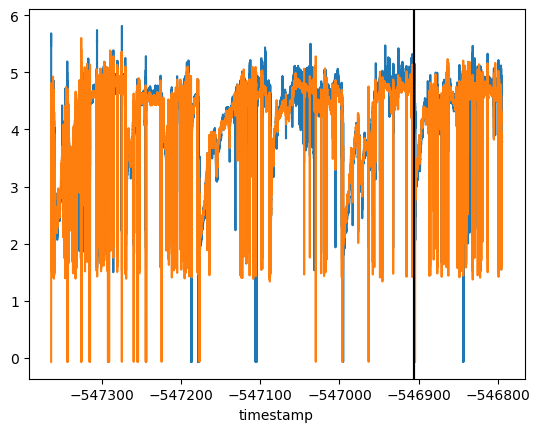

In [8]:
# PIPR STIMS - USE THIS ONE
# This is the actual stimulus administration. Make sure participant is comfortable and set up. 
# starts with a prompt to input subject ID - enter the 3 digit subject ID
# once the subject ID is entered, it will take about 2 seconds before 1st (blue) flash
# stimulus then takes 1 second, then there is about 90.5 seconds to next flash
# in total, there are 6 flashes: starting with blue then alternating with red
# this also tracks data from both pupil, so you can see both pupils on the laptop and ask participant to adjust as needed
# output from this cell should include timestamps from the flash (exactly 6)
# once 6th flash + 90s is done, there will be about 20s of "Waiting for futures..." being printed, before it is done
# it will then output: PupilGrabber done grabbing 570 seconds of pupil.0.3d, PupilGrabber done grabbing 570 seconds of pupil.1.3d
# finally, there will be a plot of each pupil against timestamps

d.turn_off()
subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)
sleep(2)
ISI = 85 # interstimulus time (seconds) = this variable + 5s due to sleep + processing
num_trials = 6 # total number of trials
run_time = ISI*num_trials + 5*num_trials + 30 # appropriate offset to account for stim duration + sleeps


# Start a new recording called "my_recording"
p.command('R my_recording')

# Wait a few seconds
sleep(2)

# Make an annotation for when the light comes on
annotation = p.new_annotation('LIGHT_ON')

# Start the .light_stamper(...) and .pupil_grabber(...)
# this only captures one eye
# pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=25) # time here is TOTAL run time
pgr_future_eye1 = p.pupil_grabber(topic='pupil.1.3d', seconds=run_time) # time here is TOTAL run time
pgr_future_eye0 = p.pupil_grabber(topic='pupil.0.3d', seconds=run_time) # time here is TOTAL run time

sleep(2)
##################################
# Administer light stimulus here #
led_list = [3,9]*3
# random.shuffle(led_list) # use this if stims should be randomized
for led in led_list:
    intensities = [0]*10
    if led == 3:
        intensities[led] = int(blue_intensity)
    else:
        intensities[led] = int(red_intensity)
    lst_future = p.light_stamper(annotation=annotation, timeout=10)
    d.set_spectrum_a(intensities)
    sleep(1.)
    d.turn_off()
    sleep(ISI)
    sleep(5) # make sure there is extra time so that trials do not overlap
##################################

# Wait for the futures
while lst_future.running() or pgr_future_eye0.running() or pgr_future_eye1.running():
    print('Waiting for futures...')
    sleep(1)

# End recording
p.command('r')

# Get the timestamp and pupil data
timestamp = lst_future.result()[1]
data_eye0 = unpack_data_pandas(pgr_future_eye0.result())
data_eye1 = unpack_data_pandas(pgr_future_eye1.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax_0 = data_eye0['diameter_3d'].plot()
ax_0.axvline(x=timestamp, color='k')
ax_1 = data_eye1['diameter_3d'].plot()
ax_1.axvline(x=timestamp, color='k')

In [9]:
# display data from pandas table
data_eye0

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
-547364.487253,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5588886100822498, 0.2640883978610068]",50.768281,0.151912,"{'center': [7.2271120613205655, 7.509527350422...","{'center': [143.67622881886575, 145.5916895381...","{'center': [1.6252358529801327, 5.485377306570...",5.465564,"{'center': [107.30661313579196, 141.2950276106...","[107.30661313579196, 141.2950276106867]",1.0,1.766823,-2.152641
-547364.480413,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5543583388648453, 0.26445493261916475]",52.626600,0.166356,"{'center': [7.2271120613205655, 7.509527350422...","{'center': [143.67622881886575, 145.5916895381...","{'center': [1.525555212122046, 5.4843203127107...",5.682292,"{'center': [106.43680106205031, 141.2246529371...","[106.43680106205031, 141.22465293712037]",1.0,1.766927,-2.164406
-547364.472510,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5542251302846122, 0.26461615776477554]",52.288030,0.163547,"{'center': [7.2271120613205655, 7.509527350422...","{'center': [143.67622881886575, 145.5916895381...","{'center': [1.5242017785604336, 5.481934891138...",5.644508,"{'center': [106.41122501464554, 141.1936977091...","[106.41122501464554, 141.1936977091631]",1.0,1.767161,-2.164597
-547364.464264,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5543227496944575, 0.2705142673167885]",50.474990,0.169382,"{'center': [7.2271120613205655, 7.509527350422...","{'center': [143.67622881886575, 145.5916895381...","{'center': [1.5352929307880467, 5.361619240618...",5.449688,"{'center': [106.42996794133583, 140.0612606751...","[106.42996794133583, 140.0612606751766]",1.0,1.778979,-2.164919
-547364.454878,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5587740558379088, 0.26453895751956935]",51.560121,0.173224,"{'center': [7.2271120613205655, 7.509527350422...","{'center': [143.67622881886575, 145.5916895381...","{'center': [1.6201831984947361, 5.474617069824...",5.555382,"{'center': [107.2846187208785, 141.20852015624...","[107.2846187208785, 141.20852015624268]",1.0,1.767879,-2.153373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-546794.536666,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5360225004348381, 0.12663452136718012]",36.209171,1.000000,"{'center': [7.2271120613205655, 7.509527350422...","{'center': [143.67622881886575, 145.5916895381...","{'center': [1.1886507194688258, 8.516292898975...",3.785104,"{'center': [102.91632008348893, 167.6861718975...","[102.91632008348893, 167.68617189750142]",1.0,1.473768,-2.194194
-546794.528553,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5358199603412284, 0.12693131454986162]",36.075265,1.000000,"{'center': [7.2271120613205655, 7.509527350422...","{'center': [143.67622881886575, 145.5916895381...","{'center': [1.1846406042469502, 8.510578206645...",3.771309,"{'center': [102.87743238551585, 167.6291876064...","[102.87743238551585, 167.62918760642657]",1.0,1.474321,-2.194633
-546794.520528,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5363432571512844, 0.12633802603843935]",36.090669,1.000000,"{'center': [7.2271120613205655, 7.509527350422...","{'center': [143.67622881886575, 145.5916895381...","{'center': [1.1954994024498982, 8.521872625602...",3.772072,"{'center': [102.9779053730466, 167.74309900061...","[102.9779053730466, 167.74309900061965]",1.0,1.473229,-2.193417


In [10]:
data_eye1

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
-547364.491863,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.7771310234392445, 0.5760121706239107]",0.000007,0.000000,"{'center': [5.232283032947718, -1.419142262533...","{'center': [132.74219741144643, 85.92226079896...","{'center': [5.51564921325189, -1.4960559060925...",-0.070512,"{'center': [149.20915650033493, 81.40566324020...","[149.20915650033493, 81.40566324020915]",0.1,1.578197,-1.543525
-547364.483660,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.26582127337220174, 0.36942996555008456]",16.055388,0.933452,"{'center': [5.232283032947718, -1.419142262533...","{'center': [132.74219741144643, 85.92226079896...","{'center': [-4.07338431172475, 2.5396848371817...",1.535452,"{'center': [51.037684487462734, 121.0694466143...","[51.037684487462734, 121.06944661438376]",0.1,1.179985,2.889769
-547364.476437,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.7771310234392445, 0.5760121706239107]",0.000007,0.000000,"{'center': [5.232283032947718, -1.419142262533...","{'center': [132.74219741144643, 85.92226079896...","{'center': [5.51564921325189, -1.4960559060925...",-0.070512,"{'center': [149.20915650033493, 81.40566324020...","[149.20915650033493, 81.40566324020915]",0.1,1.578197,-1.543525
-547364.467942,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.5007290269495038, 0.30932711377824107]",30.000096,0.798632,"{'center': [5.232283032947718, -1.419142262533...","{'center': [132.74219741144643, 85.92226079896...","{'center': [0.3541262206275979, 3.814363374612...",2.993391,"{'center': [96.13997317430473, 132.60919415457...","[96.13997317430473, 132.60919415457772]",1.0,1.043042,-2.145190
-547364.460424,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.7771310234392445, 0.5760121706239107]",0.000007,0.000000,"{'center': [5.232283032947718, -1.419142262533...","{'center': [132.74219741144643, 85.92226079896...","{'center': [5.51564921325189, -1.4960559060925...",-0.070512,"{'center': [149.20915650033493, 81.40566324020...","[149.20915650033493, 81.40566324020915]",0.1,1.578197,-1.543525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-546794.540345,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.4270511483385908, 0.6926834817897813]",38.718710,1.000000,"{'center': [5.232283032947718, -1.419142262533...","{'center': [132.74219741144643, 85.92226079896...","{'center': [-1.1534905390985726, -3.9781525026...",3.846572,"{'center': [81.99382048100944, 59.004771496361...","[81.99382048100944, 59.00477149636198]",1.0,1.819596,-2.257502
-546794.532309,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.4275235993793061, 0.6924084526943592]",38.973233,1.000000,"{'center': [5.232283032947718, -1.419142262533...","{'center': [132.74219741144643, 85.92226079896...","{'center': [-1.144310609054279, -3.97157455106...",3.871571,"{'center': [82.08453108082678, 59.057577082683...","[82.08453108082678, 59.05757708268301]",1.0,1.818943,-2.256188
-546794.524544,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.4269740652571936, 0.6923803234924172]",38.964955,1.000000,"{'center': [5.232283032947718, -1.419142262533...","{'center': [132.74219741144643, 85.92226079896...","{'center': [-1.1553362412913541, -3.9718840204...",3.871409,"{'center': [81.97902052938117, 59.062977889455...","[81.97902052938117, 59.0629778894559]",1.0,1.818974,-2.257609


In [11]:
# this saves the raw data - IMPORTANT
import os  

# os.makedirs('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata', exist_ok=True) 

data_eye0.to_csv(path_base + subj_base + '-eye0.csv')
data_eye1.to_csv(path_base + subj_base + '-eye1.csv')

**DATA PROCESSING BEGINS BELOW**

In [12]:
samples_eye0 = data_eye0
samples_eye1 = data_eye1

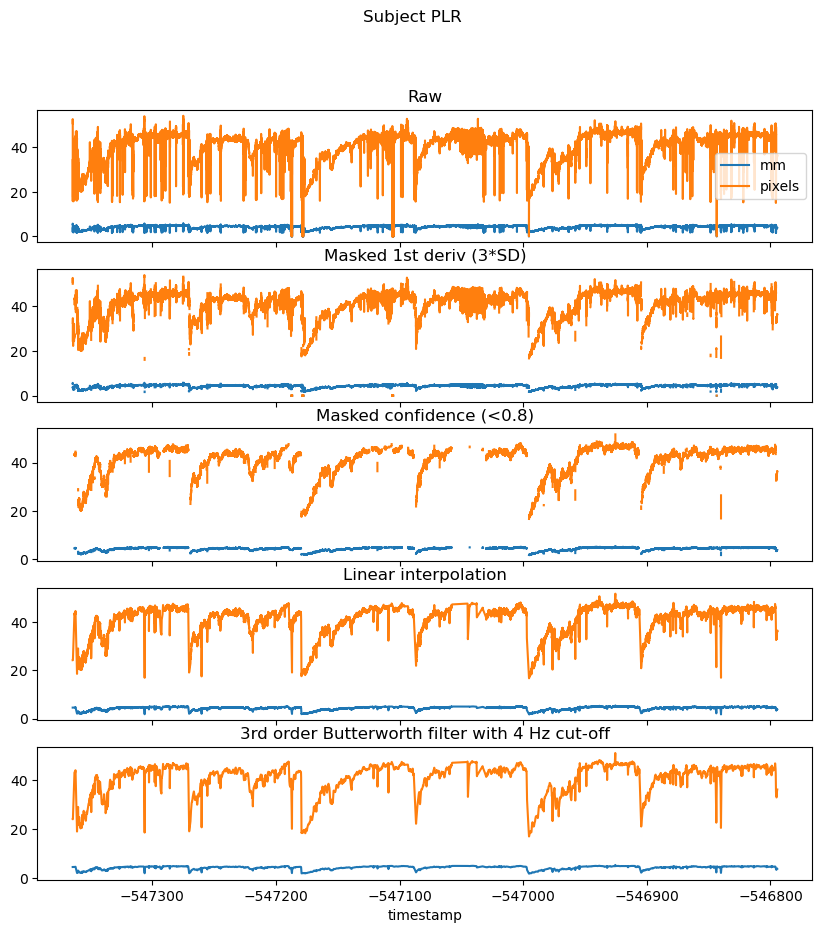

In [13]:
# Filtering and processing for eye 0
from pyplr import graphing
from pyplr import preproc
import matplotlib.pyplot as plt

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye0[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye0 = preproc.mask_pupil_first_derivative(
    samples_eye0, threshold=3.0, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye0 = preproc.mask_pupil_confidence(
    samples_eye0, threshold=0.8, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye0 = preproc.interpolate_pupil(
    samples_eye0, interp_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye0 = preproc.butterworth_series(
    samples_eye0, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye0[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [14]:
# export butterworth processed sample data for eye 0 - IMPORTANT
samples_eye0.to_csv(path_base + subj_base + '-butterworth-eye0.csv') # raw data

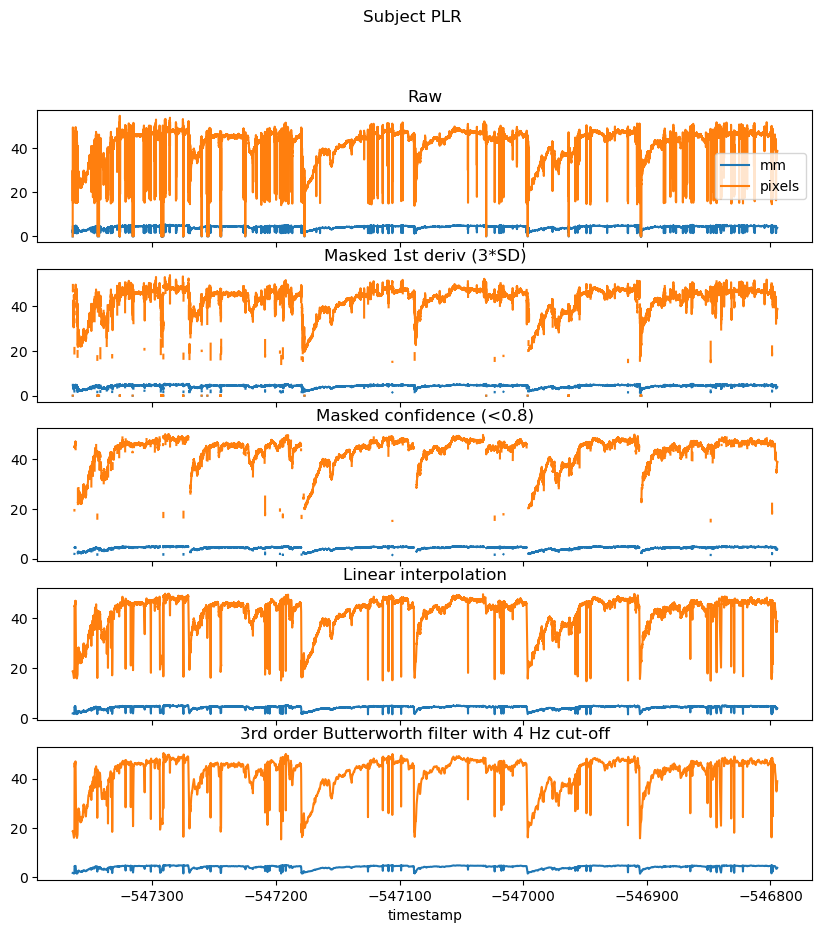

In [15]:
# Filtering and processing for eye 1
# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye1[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye1 = preproc.mask_pupil_first_derivative(
    samples_eye1, threshold=3.0, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye1 = preproc.mask_pupil_confidence(
    samples_eye1, threshold=0.8, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye1 = preproc.interpolate_pupil(
    samples_eye1, interp_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye1 = preproc.butterworth_series(
    samples_eye1, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye1[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [16]:
# export butterworth processed sample data for eye 1 - IMPORTANT
samples_eye1.to_csv(path_base + subj_base + '-butterworth-eye1.csv') # raw data
# can stop here if necessary

### **STOP HERE AND DO ANALYSIS LATER**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# df_pipr = pd.read_csv("C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/sub-999_ses-02_dat-20230419.csv")
df_pipr_eye0 = pd.read_csv(path_base + subj_base + '-eye0.csv')
df_pipr_eye1 = pd.read_csv(path_base + subj_base + '-eye1.csv')

# Print header names
# print(df_pipr.columns)

# Extract the column with header "timestamp"
timestamps_eye0 = df_pipr_eye0["timestamp"]
timestamps_eye1 = df_pipr_eye1["timestamp"]
# Extract the column with header "diameter_3d"
diam_3d_eye0 = df_pipr_eye0["diameter_3d"]
diam_3d_eye1 = df_pipr_eye1["diameter_3d"]

In [ ]:
fig = plt.figure()
# plot eye0 in red, eye1 in blue
plt.plot(timestamps_eye0, diam_3d_eye0, 'r') # this should be the smoothed out data - if not, check
plt.plot(timestamps_eye1, diam_3d_eye1, 'b') # this should be the smoothed out data - if not, check

This is copied from the output of cell 11
> Light stamped on frame.world at 31031.85642
> Waiting for a light to stamp...
> Light stamped on frame.world at 31158.285079
> Waiting for a light to stamp...
> Light stamped on frame.world at 31284.777037
> Waiting for a light to stamp...
> Light stamped on frame.world at 31411.245427
> Waiting for a light to stamp...
> Light stamped on frame.world at 31537.774172
> Waiting for a light to stamp...
> Light stamped on frame.world at 31664.31662

**Edit Cell Below with Timestamps**

In [ ]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps_eye0 <= 500548.684061)[0][-1]
stamp2 = np.where(timestamps_eye0 <= 500640.209426)[0][-1]
stamp3 = np.where(timestamps_eye0 <= 500731.603996)[0][-1]
stamp4 = np.where(timestamps_eye0 <= 500823.042564)[0][-1]
stamp5 = np.where(timestamps_eye0 <= 500914.477428)[0][-1]
stamp6 = np.where(timestamps_eye0 <= 501005.93432)[0][-1]
stamps_eye0 = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps_eye0

In [ ]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps_eye1 <= 500548.684061)[0][-1]
stamp2 = np.where(timestamps_eye1 <= 500640.209426)[0][-1]
stamp3 = np.where(timestamps_eye1 <= 500731.603996)[0][-1]
stamp4 = np.where(timestamps_eye1 <= 500823.042564)[0][-1]
stamp5 = np.where(timestamps_eye1 <= 500914.477428)[0][-1]
stamp6 = np.where(timestamps_eye1 <= 501005.93432)[0][-1]
stamps_eye1 = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps_eye1

In [ ]:
from pyplr import utils
from copy import deepcopy

In [ ]:
df_data_eye0 = df_pipr_eye0[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1 = df_pipr_eye1[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1

**Extract ranges from samples based on event timing and sample count, eye 0**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [ ]:
samples_eye0 = df_data_eye0
event_starts_eye0 = stamps_eye0
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs_eye0 = (
    np.searchsorted(samples_eye0.index, event_starts_eye0, "left") + offset
)
range_duration = duration

In [ ]:
range_idxs_eye0

In [ ]:
# make a hierarchical index for eye 0
samples_eye0["orig_idx"] = samples_eye0.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts_eye0))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye0 = pd.DataFrame()
idx = 0
for start_idx in range_idxs_eye0:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye0):
        end_idx = len(samples_eye0) - 1
    new_df_eye0 = deepcopy(
        samples_eye0.loc[samples_eye0.index[start_idx] : samples_eye0.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye0 = pd.concat([df_eye0, new_df_eye0])
    idx += 1
    
# if there is an error that doesn't allow the new indices to be set (size mismatch), use the if loop below
if (len(df_eye0)!= len(midx)):
    df_test = df_eye0
    temp_df = deepcopy(df_eye0.loc[df_eye0.index[-1] : df_eye0.index[-1]])
    while len(df_eye0) != len(midx):
        df_eye0= pd.concat([df_eye0, temp_df])

df_eye0.index = midx
print("Extracted ranges for {} events".format(len(event_starts_eye0)))

In [ ]:
df_eye0.index

**Extract ranges from samples based on event timing and sample count, eye 1**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [ ]:
samples_eye1 = df_data_eye1
event_starts_eye1 = stamps_eye1 
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs_eye1 = (
    np.searchsorted(samples_eye1.index, event_starts_eye1, "left") + offset
)
range_duration = duration

In [ ]:
range_idxs_eye1

In [ ]:
# make a hierarchical index for eye 1
samples_eye1["orig_idx"] = samples_eye1.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts_eye1))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye1 = pd.DataFrame()
idx = 0
for start_idx in range_idxs_eye1:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye1):
        end_idx = len(samples_eye1) - 1
    new_df_eye1 = deepcopy(
        samples_eye1.loc[samples_eye1.index[start_idx] : samples_eye1.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye1 = pd.concat([df_eye1, new_df_eye1])
    idx += 1
# if there is an error that doesn't allow the new indices to be set (size mismatch), use the if loop below
if (len(df_eye1)!= len(midx)):
    df_test = df_eye1
    temp_df = deepcopy(df_eye1.loc[df_eye1.index[-1] : df_eye1.index[-1]])
    while len(df_eye1) != len(midx):
        df_eye1= pd.concat([df_eye1, temp_df])
df_eye1.index = midx
print("Extracted ranges for {} events".format(len(event_starts_eye1)))

In [ ]:
df_eye1.index

**Re-run the processing on the multi-index data, eye 0**

In [ ]:
from pyplr import graphing
from pyplr import preproc
# Calculate baselines
baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye0 = preproc.percent_signal_change(
    df_eye0, baselines_eye0, ['diameter_3d', 'diameter'])
df_eye0

In [ ]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120
samples_eye0 = df_eye0

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye0[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye0 = preproc.mask_pupil_first_derivative(
    samples_eye0, threshold=3.0, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye0 = preproc.mask_pupil_confidence(
    samples_eye0, threshold=0.8, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye0 = preproc.interpolate_pupil(
    samples_eye0, interp_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye0 = preproc.butterworth_series(
    samples_eye0, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye0[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [ ]:
samples_eye0 # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

In [ ]:
df_eye0

**Re-run processing on multi-index data, eye 1**

In [ ]:
# Calculate baselines
baselines_eye1 = df_eye1.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye1 = preproc.percent_signal_change(
    df_eye1, baselines_eye1, ['diameter_3d', 'diameter'])
df_eye1

In [ ]:
# Sampling frequency
SAMPLE_RATE = 120
samples_eye1 = df_eye1

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye1[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye1 = preproc.mask_pupil_first_derivative(
    samples_eye1, threshold=3.0, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye1 = preproc.mask_pupil_confidence(
    samples_eye1, threshold=0.8, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye1 = preproc.interpolate_pupil(
    samples_eye1, interp_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye1 = preproc.butterworth_series(
    samples_eye1, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye1[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [ ]:
samples_eye1 # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

In [ ]:
df_eye1

**Convert the index-level samples to time (s)**:

In [ ]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df_eye0.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df_eye0.index = df_eye0.index.set_levels(
    levels=new_onset, level='onset')

In [ ]:
df_eye0["colour"] = ""

In [ ]:
for (event, onset) in df_eye0.index:
    if event%2==1:
        df_eye0["colour"][event,onset] = "red"
    else:
        df_eye0["colour"][event,onset] = "blue"

In [ ]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df_eye1.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df_eye1.index = df_eye1.index.set_levels(
    levels=new_onset, level='onset')

In [ ]:
df_eye1["colour"] = ""

In [ ]:
for (event, onset) in df_eye1.index:
    if event%2==1:
        df_eye1["colour"][event,onset] = "red"
    else:
        df_eye1["colour"][event,onset] = "blue"

**Plot the PIPR:**

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df_eye0.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs_eye0 = (df_eye0.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs_eye0, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df_eye0['id'][0][0]))

In [ ]:
import os
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + subj_base + '-eye0.png')

In [ ]:
df_eye0 # check all is as expected before sending to csv

In [ ]:
df_eye0.to_csv(path_base + subj_base + '-processed-eye0.csv') # processed data with adjusted onset indices (time in seconds)

In [ ]:
samples_eye0["diameter_3d"].plot()

In [ ]:
avgs_eye0.to_csv(path_base + subj_base + '-average-pipr-eye0.csv') # processed data with adjusted onset indices (time in seconds)

In [ ]:
df_eye1

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df_eye1.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs_eye1 = (df_eye1.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs_eye1, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df_eye1['id'][0][0]))

In [ ]:
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + subj_base + '-eye1.png')

In [ ]:
df_eye1 # check all is as expected before sending to csv

In [ ]:
df_eye1.to_csv(path_base + subj_base + '-processed-eye1.csv') # processed data with adjusted onset indices (time in seconds)

In [ ]:
samples_eye1["diameter_3d"].plot()

In [ ]:
avgs_eye1.to_csv(path_base + subj_base + '-average-pipr-eye1.csv') # processed data with adjusted onset indices (time in seconds)

**Compute the pupillary light response (optional, skip for now):**

In [ ]:
# adapt this to separate red and blue
from pyplr.plr import PLR

average_plr = df.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

In [ ]:
fig = plr.plot(vel=True, acc=True, print_params=True)

In [ ]:
params = plr.parameters()
params

**Compute the PIPR:**

In [ ]:
# code to calculate PIPR at given time
pipr_time = 7 # measure PIPR at t=7s (6s after stimulus turned off)
print(avgs_eye0.loc[avgs_eye0["onset"] == pipr_time])
print(avgs_eye1.loc[avgs_eye1["onset"] == pipr_time])

In [ ]:
# eye 0
blue_d_pipr_eye0 = avgs_eye0["diameter_3d"][480]
red_d_pipr_eye0 = avgs_eye0["diameter_3d"][4080]
blue_d_pipr_pc_eye0 = avgs_eye0["diameter_3d_pc"][480]
red_d_pipr_pc_eye0 = avgs_eye0["diameter_3d_pc"][4080]
pipr_diff_eye0 = red_d_pipr_eye0 - blue_d_pipr_eye0
pipr_pc_diff_eye0 = red_d_pipr_pc_eye0 - blue_d_pipr_pc_eye0
print("PIPR (Absolute Difference), Eye 0: ", pipr_diff_eye0)
print("PIPR (Percent Change), Eye 0: ", pipr_pc_diff_eye0)

In [ ]:
# eye 1
blue_d_pipr_eye1 = avgs_eye1["diameter_3d"][480]
red_d_pipr_eye1 = avgs_eye1["diameter_3d"][4080]
blue_d_pipr_pc_eye1 = avgs_eye1["diameter_3d_pc"][480]
red_d_pipr_pc_eye1 = avgs_eye1["diameter_3d_pc"][4080]
pipr_diff_eye1 = red_d_pipr_eye1 - blue_d_pipr_eye1
pipr_pc_diff_eye1 = red_d_pipr_pc_eye1 - blue_d_pipr_pc_eye1
print("PIPR (Absolute Difference), Eye 1: ", pipr_diff_eye1)
print("PIPR (Percent Change), Eye 1: ", pipr_pc_diff_eye1)